In [1]:
import re, numpy as np, pandas as pd
from transformers import BertTokenizer, BertPreTrainedModel, BertModel,BertConfig,BertForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput
from torch import nn
import torch
import matplotlib.pyplot as plt

In [2]:
class BertForTokenClassification(BertPreTrainedModel):
    
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=None,
    ):
    
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )





In [3]:
tag2idx ={'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 
'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16, 'PAD': 17}

In [4]:
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True,input_ids=True,output_attentions=True)
model = BertModel.from_pretrained('bert-base-uncased',config=config) #pre-trained
#NER 
model_token =  BertForTokenClassification.from_pretrained(
    "bert-base-uncased",num_labels=len(tag2idx))
model_token = torch.load('NER2', map_location={'cuda:0': 'cpu'})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'c

In [5]:
# read the sentiment sample
sentiment_train = pd.read_csv("attention1.csv")

# extract the 'sentiment' column to compare what's different between 0(negative) and 1(positive)
sentiment_class = sentiment_train.loc[0:10,"sentiment"]


In [6]:
# put the first 10 samples into tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = [0]*10
outputs = [0]*10

for i in range(10):
    text = str(sentiment_train.loc[i,'Sentiment'])
    inputs[i] = tokenizer(text, return_tensors="pt")
    outputs[i] = model(**inputs[i])

output_attention = outputs[1].attentions

In [23]:
output_attention[0].shape

torch.Size([1, 12, 345, 345])

In [18]:
outputs[0][1][0].shape

torch.Size([768])

In [ ]:
# outputs[i]     -> the i-th data i get
#        [0~3]   -> 0:n個詞的vector, 1:attention的vector, 2: hidden的vector, 3:attention對於每一層中每個字和上一個字的分布情況
#        [0~12]  -> 如果使用hidden，則此層代表訓練模型中的第幾層，沒有使用則忽略此層
#        [0]     -> 目前還不知道有甚麼用...
#        [0~n-1] -> 第幾個字
#        [0~767] -> 第幾維詞向量

# outputs[i][2][12][0][0]: 第i組data其第12層hidden state的[CLS]


# get [CLS] value of the 12 hidden-layers of the chosen 10 data
sumList = [[0]*13]*10
labelList = [0]*10

for i in range(10):
    for j in range(13): 
        for k in range(768):
            # use .item() to extract the value from torch.tensor
            x = outputs[i][2][j][0][0][k]
            sumList[i][j] += x.item()



In [ ]:
# X-axis: 0~12 ayers of the hidden state
x_axis = [0,1,2,3,4,5,6,7,8,9,10,11,12]

labelList = [0]*10
for i in range(10):
    labelList[i] = sentiment_class.loc[i]

# set up the line-chart
# for i in range(10):
#     labelString = str(str(i+1)+":"+str(labelList[i]))
#     plt.figure(figsize=(10,5),dpi=100,linewidth=2)          # size
#     plt.plot(x_axis,sumList[i],'s-',color='red',label=labelString)
#     plt.title(i,x=0.5,y=1.03)                               # title
#     plt.xlabel("layers", fontsize=30, labelpad = 15)        # x-axis meaning
#     plt.ylabel("value", fontsize=30, labelpad = 20)         # y-axis meaning
#     plt.legend(loc="best", fontsize=20)                   # line meaning
#     plt.show()

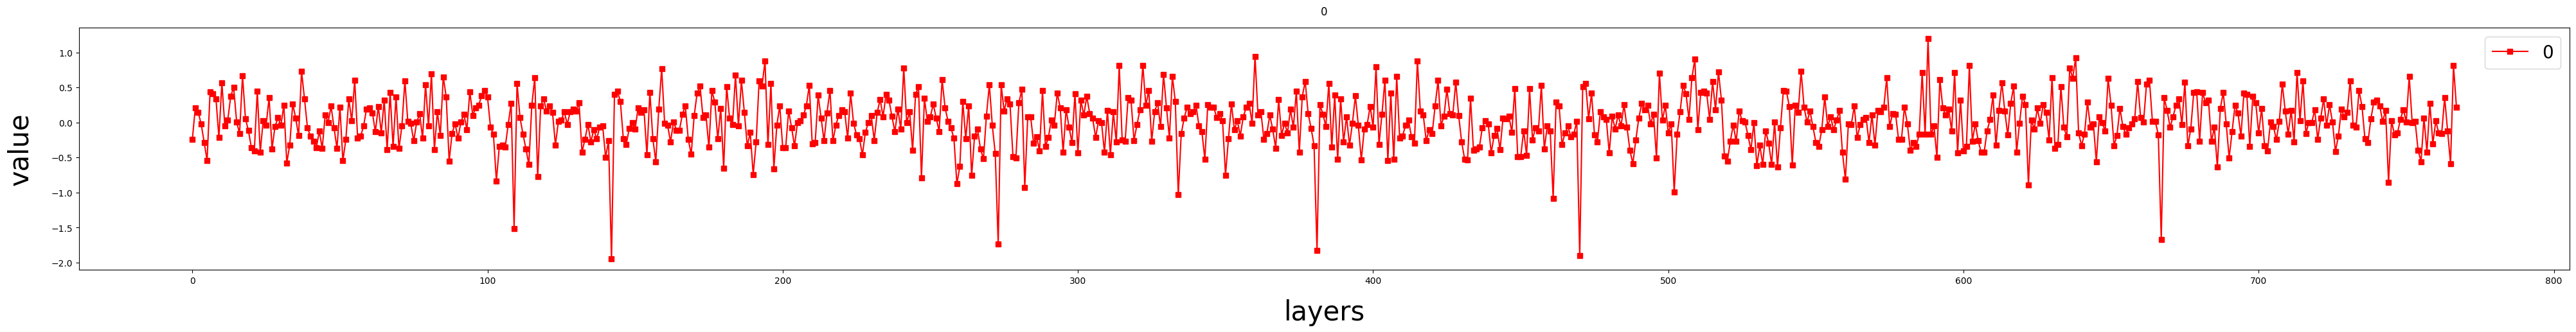

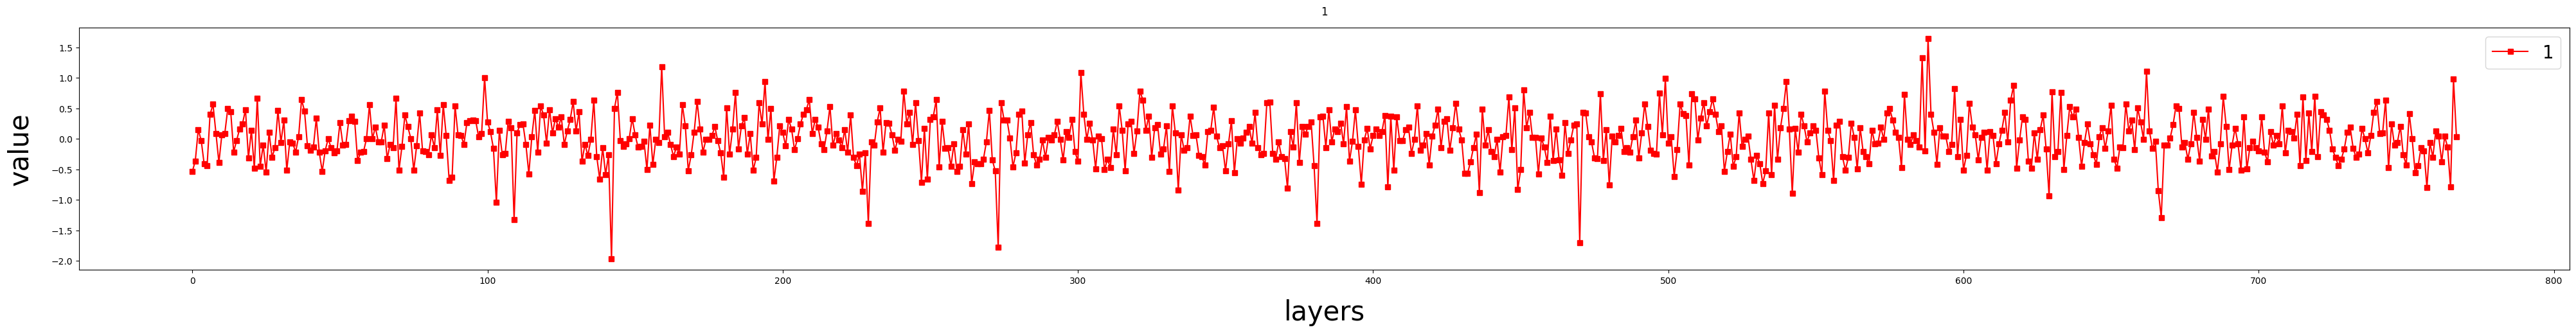

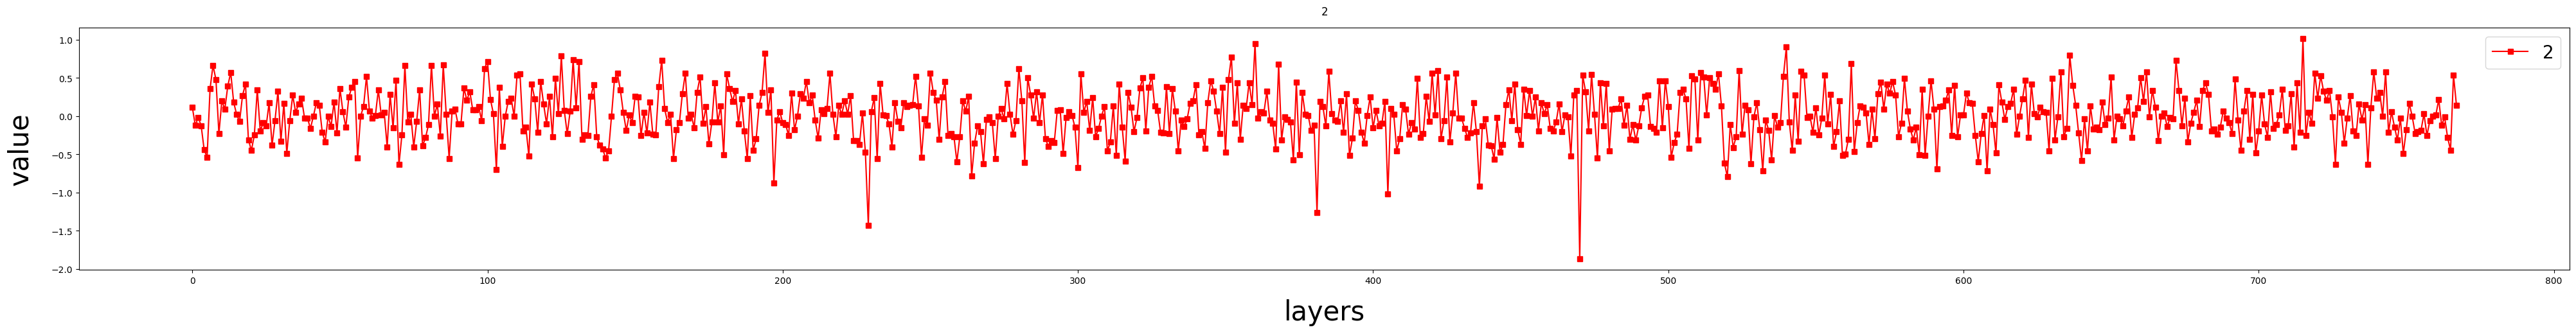

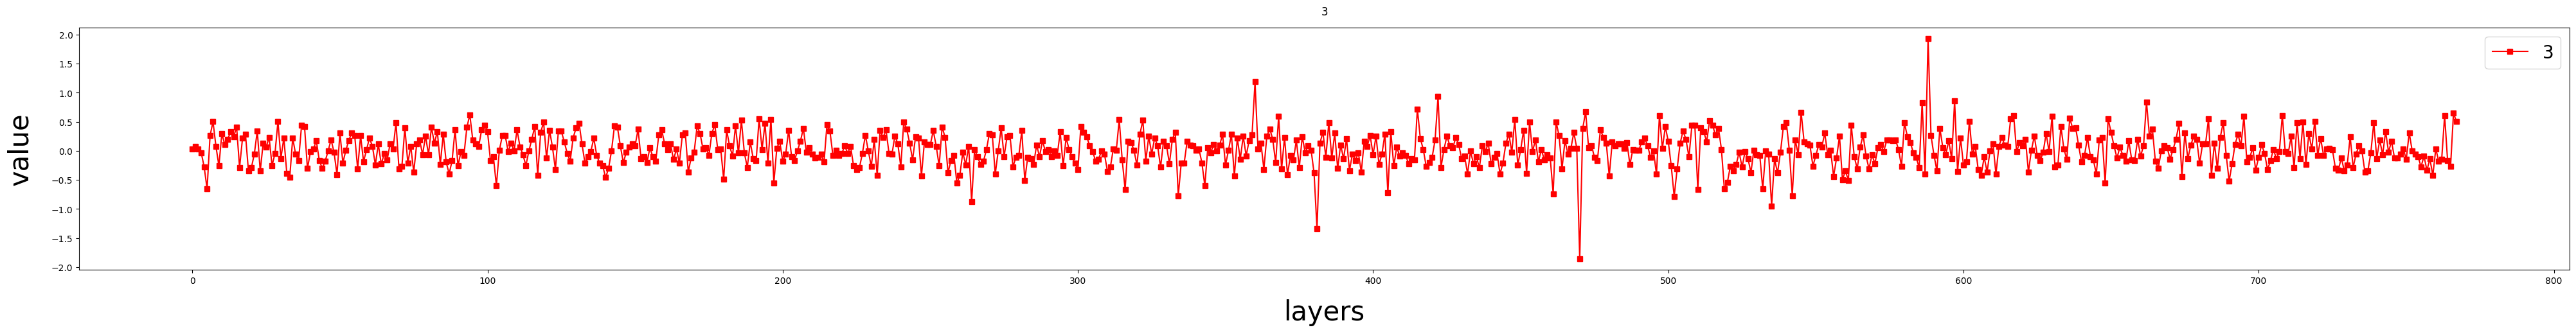

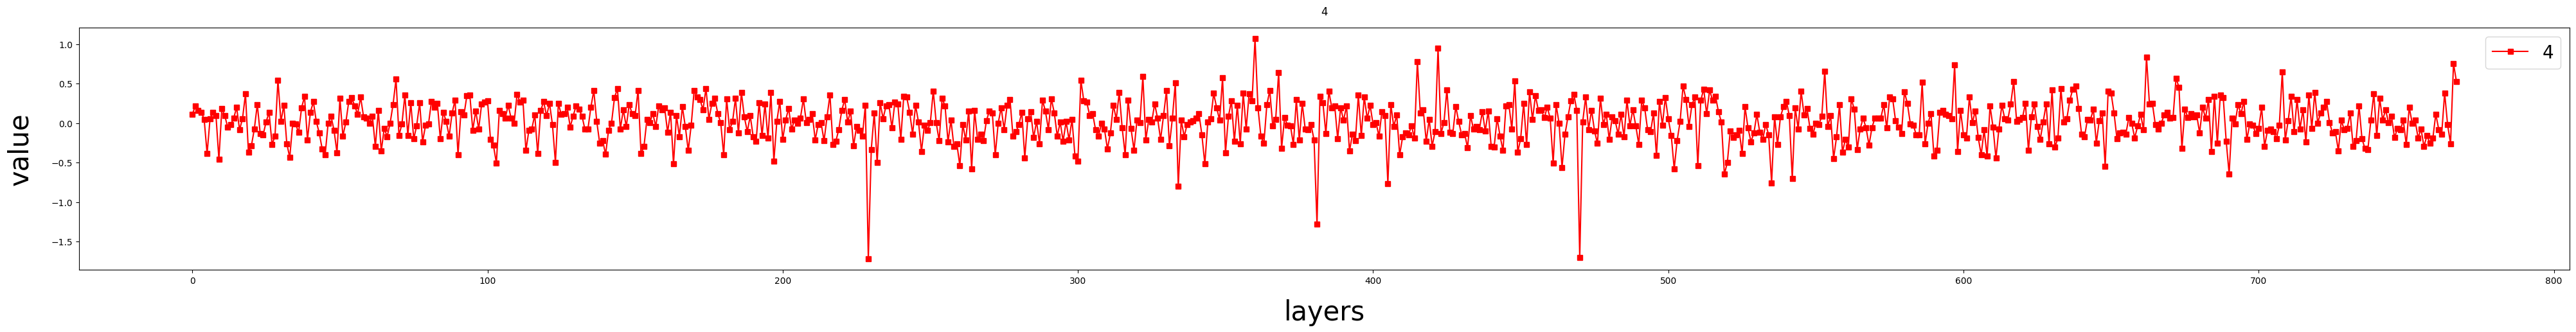

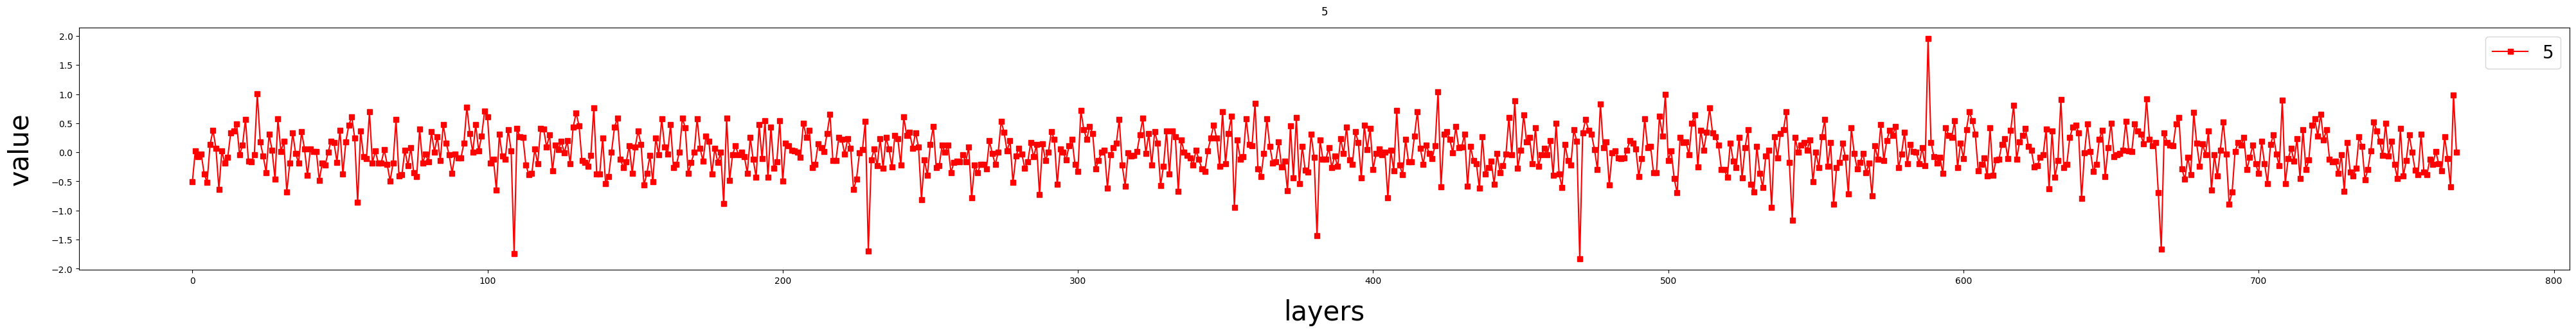

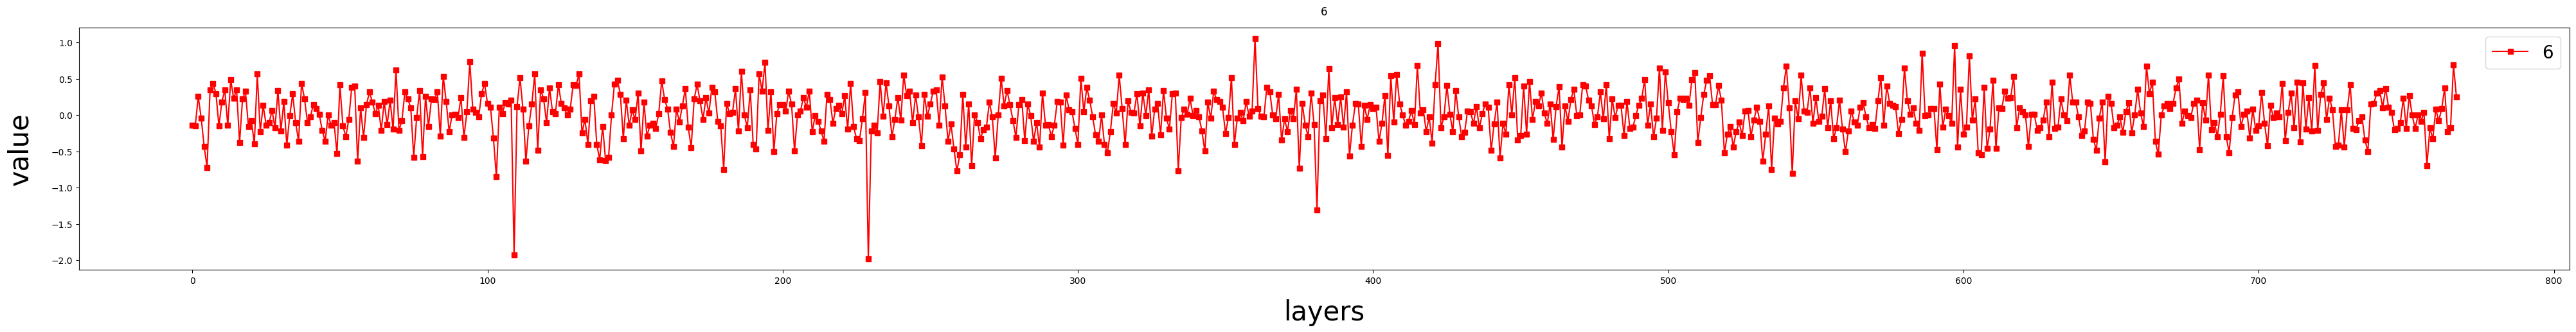

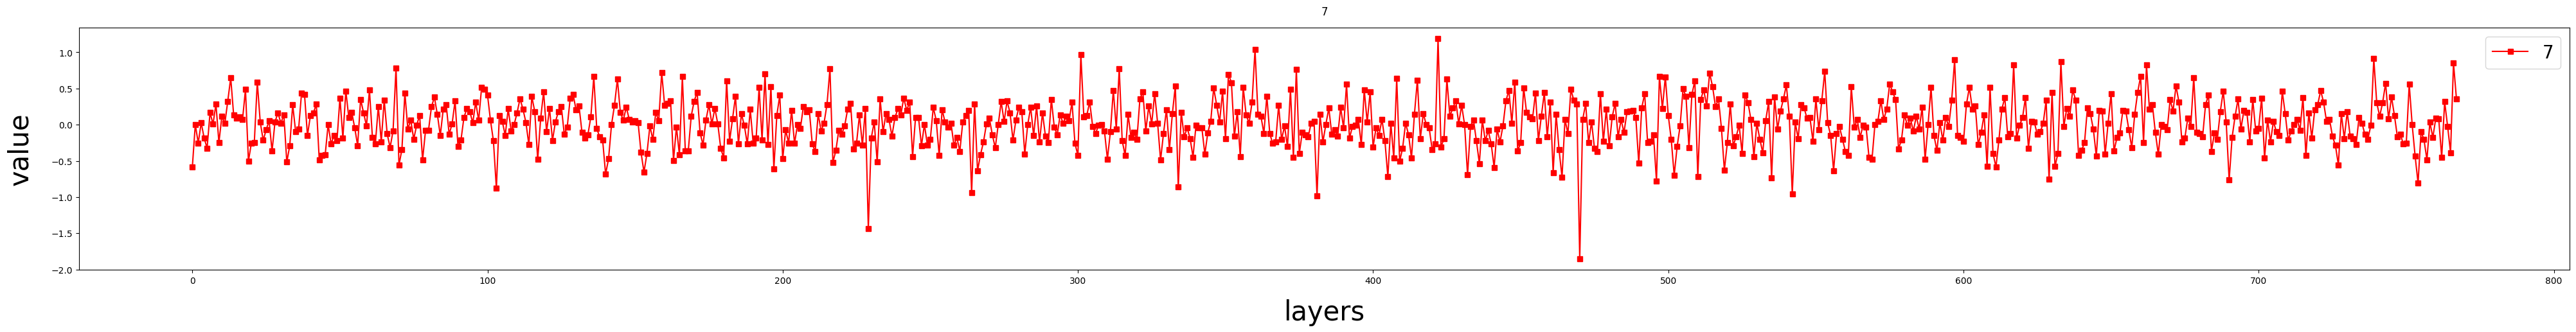

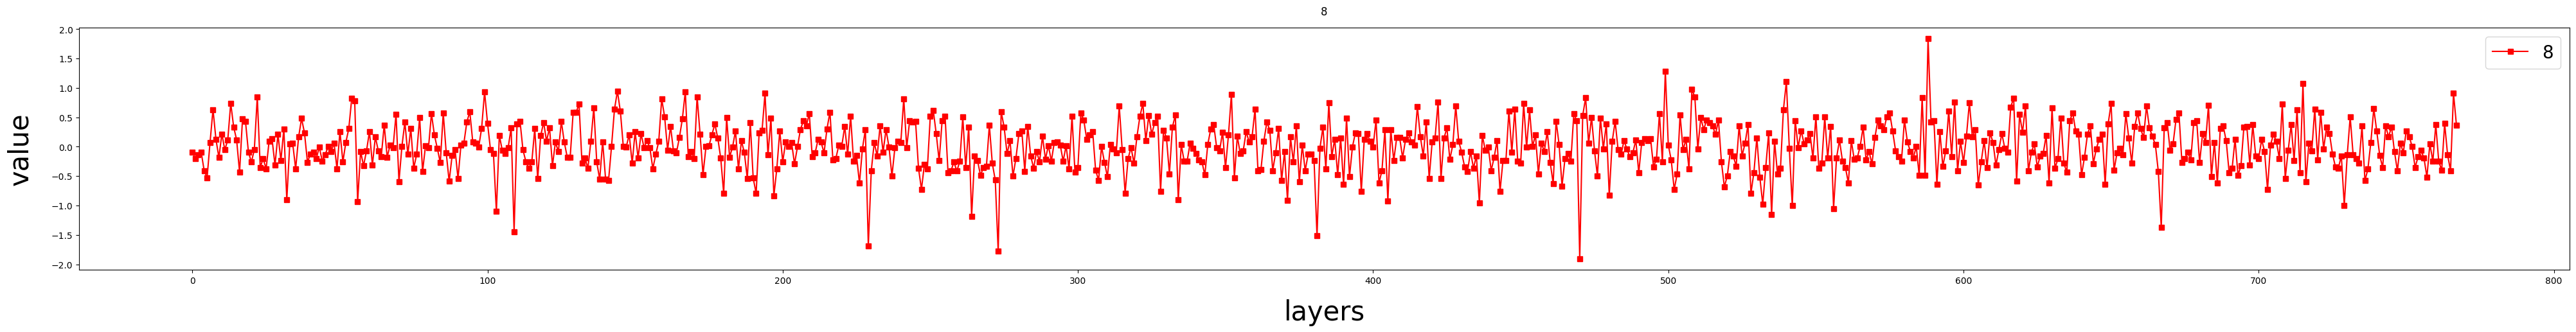

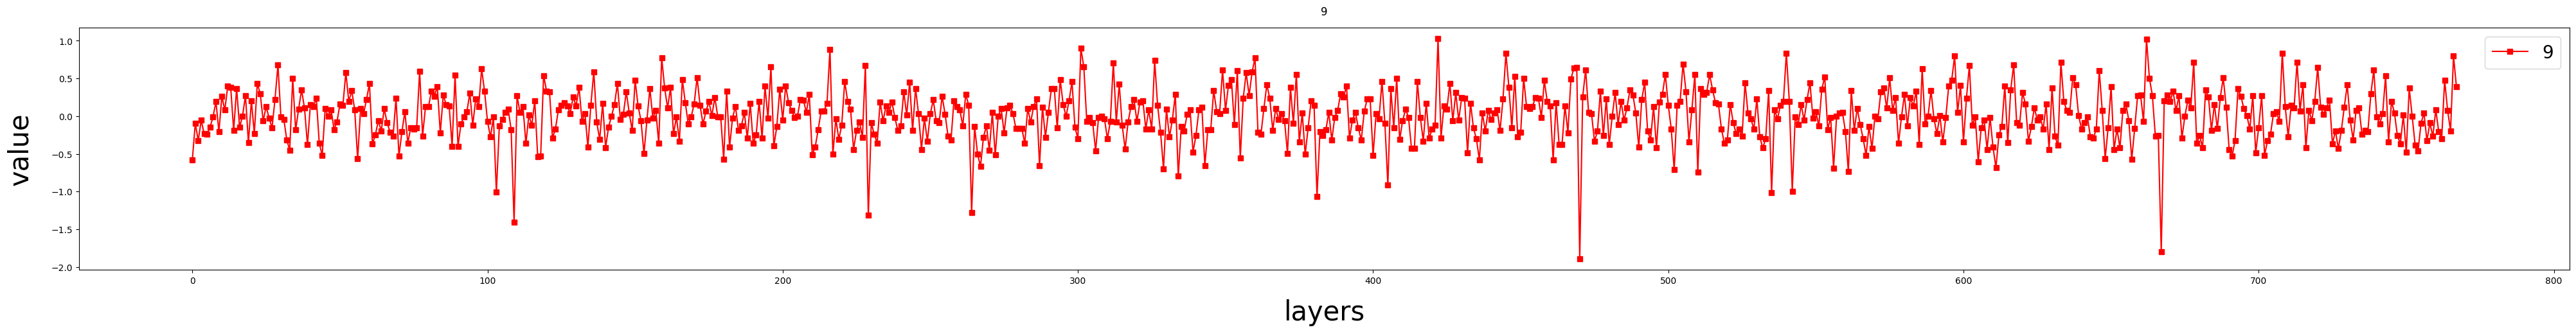

In [ ]:
x_axis2 = []
for i in range(768):
    x_axis2.append(i)


for i in range(10):
    testList = [0]*768
    for k in range(768):
        # use .item() to extract the value from torch.tensor
        x = outputs[i][2][12][0][0][k]
        val = x.item()
        
        # ignore extremum
        if val > 2 or val < -2:
            testList[k] = 0
        else:
            testList[k] = val



    plt.figure(figsize=(50,5),dpi=100,linewidth=2)          # size
    plt.plot(x_axis2,testList,'s-',color='red',label=i)
    plt.title(i,x=0.5,y=1.03)                               # title
    plt.xlabel("layers", fontsize=30, labelpad = 15)        # x-axis meaning
    plt.ylabel("value", fontsize=30, labelpad = 20)         # y-axis meaning
    plt.legend(loc="best", fontsize=20)                   # line meaning
    plt.show()

In [ ]:
sentiment_class

0     0
1     1
2     0
3     0
4     0
5     1
6     0
7     1
8     0
9     1
10    0
Name: sentiment, dtype: int64